In [1]:
import pygraphviz
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, ConnectionPatch
import pygraphviz
import math

In [11]:
class Node:
    def __init__(self, _id, number, color='green'):
        self.id = _id
        self.number = number
        self.in_neighbours = []
        self.out_neighbours = []
        self.circle = Circle(xy=np.zeros(2), radius = .1, color = color, alpha=.5, zorder=100)

    def add_out_neighbour(self, neighbour, weight=1):
        if neighbour not in self.out_neighbours:
            self.out_neighbours.append((neighbour, weight))

    def add_in_neighbour(self, neighbour, weight=1):
        if neighbour not in self.in_neighbours:
            self.in_neighbours.append((neighbour, weight))

    def has_neighbour(self,neighbour):
        if neighbour in [node for node,_ in self.out_neighbours]:
            return True
        if neighbour in [node for node,_ in self.in_neighbours]:
            return True
        else:
            return False
    def degree(self):
        return len(self.out_neighbours) + len(self.in_neighbours)

    def show_label(self, ax):
        ax.text(*self.circle.center, str(self.id), size=6, ha='center', va='baseline', alpha=.5)

class TreeNode(Node):
    def __init__(self, label, tree_dict=None):
        super().__init__(label)
        self.children = set()
        self.parent = None
        self.non_tree_neighbours = []
        self.width = None
        self.level = None
        self.height = None
        self.x_y_ratio = None

    @classmethod
    def build_tree_from_dict(cls, tree_dict):
        node_instances = {}

        def build_tree_helper(label):
            if label not in node_instances:
                node_instances[label] = TreeNode(label)

            node = node_instances[label]

            if label in tree_dict:
                for child, weight in tree_dict[label]:
                    child_node = build_tree_helper(child.id)
                    node.add_child(child_node, weight)

            return node

        root_label = next(iter(tree_dict))
        root_node = build_tree_helper(root_label)

        return root_node

    def add_child(self, child, weight=1):
        child.parent = self
        self.children.add((child, weight))

    def get_height(self):
        if not self.children:
            return 0
        self.height = 1 + max([child[0].get_height() for child in self.children])
        return self.height

    def compute_drawing_params(self):
        self.calculate_width()
        self.get_height()
        self.x_y_ratio = max((self.width//2) // self.height, self.height // (self.width//2))

    def get_level(self):
        self.level = 0
        current_parent = self.parent
        while current_parent:
            current_parent = current_parent.parent
            self.level += 1
        return self.level

    def calculate_width(self):
        self.width = 0
        children_widths = [child[0].calculate_width() for child in self.children]
        self.width = 1 + sum(children_widths)
        return self.width

    def compute_coordinates(self, x, y, x_y_ratio=1):
        self.coordinates = (x, y)
        if self.children:
            total_children_width = sum([child[0].width for child in self.children])
            starting_x = x - total_children_width // 2
            for child, _ in self.children:
                child_x = starting_x + child.width // 2
                child.compute_coordinates(child_x, 0 - child.get_level() * x_y_ratio, x_y_ratio)
                starting_x += child.width

    def draw_tree(self, labels=True, non_tree_edges=False):
        self.compute_drawing_params()
        self.compute_coordinates(0, 0, self.x_y_ratio)
        fig = plt.figure()
        ax = fig.gca()
        plt.axis(False)

        def draw_patch(node, ax):
            ax.add_patch(Circle(xy=node.coordinates, radius=0.5, color='green', alpha=0.3))
            if labels:
                plt.text(*node.coordinates, str(node.id), size=6, ha='center', va='baseline', alpha=0.5)
            if node.children:
                for child, _ in node.children:
                    ax.add_patch(ConnectionPatch(node.coordinates, child.coordinates, 'data', lw=0.5, color='grey'))
                    draw_patch(child, ax)
            if non_tree_edges:
                for nt_neighbour_label in node.non_tree_neighbours:
                    nt_neighbour_node = self.find_tree_node(nt_neighbour_label)
                    ax.add_patch(ConnectionPatch(node.coordinates, nt_neighbour_node.coordinates, 'data', lw=0.1, color='blue', linestyle=":"))

        draw_patch(self, ax)

        margin = 2
        x_lim = self.width // 2
        ax.set_xlim((-x_lim - margin, x_lim + margin))
        ax.set_ylim((-self.height * self.x_y_ratio - margin, 0 + margin))
        plt.grid(which='minor', axis='y', linewidth=0.5, linestyle=':')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_frame_on(False)
        ax.tick_params(tick1On=False, which='both')
        ax.minorticks_on()
        plt.show()
        return fig

    def find_tree_node(self, label):
        queue = [self]
        while queue:
            current_node = queue.pop(0)
            if current_node.id == label:
                return current_node
            queue.extend([child[0] for child in current_node.children])

class Edge:
    def __init__(self, n1, n2, weight=1, directed=False):
        self.directed = directed
        self.node1, self.node2 = n1, n2
        self.circle1 = n1.circle
        self.circle2 = n2.circle
        self.inverted = False
        self.weight = weight
        self.fig_coordinates = None
        if self.directed:
            if self.inverted:
                self.line = ConnectionPatch(self.circle1.center, self.circle2.center, "data", "data", lw=0.7, color='red', arrowstyle="->")
            else:
                self.line = ConnectionPatch(self.circle1.center, self.circle2.center, "data", "data", lw=0.7, color='red', arrowstyle="->")
        else:
            self.line = ConnectionPatch(self.circle1.center, self.circle2.center, "data", "data", lw=0.7, color='grey',zorder=1)

    def update_line(self, ax1=None, ax2=None, color="grey", coordsA='data', coordsB='data'):
        if self.directed:
            if self.inverted:
                self.line = ConnectionPatch(self.circle1.center, self.circle2.center, coordsA=coordsA, coordsB=coordsB, axesA=ax1, axesB=ax2, lw=0.4, color=color, arrowstyle="->")
            else:
                self.line = ConnectionPatch(self.circle1.center, self.circle2.center, coordsA=coordsA, coordsB=coordsB, axesA=ax1, axesB=ax2, lw=0.4, color=color, arrowstyle="->")
        else:
            self.line = ConnectionPatch(self.circle1.center, self.circle2.center, coordsA=coordsA, coordsB=coordsB, axesA=ax1, axesB=ax2, lw=0.4, color=color)

    def get_fig_coordinates(self, ax1, ax2):
        """
        Transforms edge node coordinates from data space to figure space.

        Args:
            ax1 (matplotlib.axes.Axes): Axes instance for node1.
            ax2 (matplotlib.axes.Axes): Axes instance for node2.

        Returns:
            tuple: A tuple containing the start and end coordinates of the edge in figure space.
        """
        fig = ax1.figure

        # Transform from data space to display space
        start_display = ax1.transData.transform(self.node1.circle.center)
        end_display = ax2.transData.transform(self.node2.circle.center)

        # Transform from display space to figure space
        transFigure = fig.transFigure.inverted()
        start_fig = transFigure.transform(start_display)
        end_fig = transFigure.transform(end_display)
        self.fig_coordinates = start_fig, end_fig
        return start_fig, end_fig


In [63]:

class Graph:
    def __init__(self, incoming_dot_file=None, directed = False, subgraphs = False, a_subgraph = False, selected_subgraphs=None,weight_name="weight"):
        # directed graph
        self.directed = directed
        self.feedback_set = set()
        # graph nodes and edges
        self.nodes, self.edges = {}, {}
        self.subgraphs = None
        if incoming_dot_file:
            self.load_graph(incoming_dot_file, subgraphs=subgraphs, selected_subgraphs=selected_subgraphs, weight_name=weight_name)

        # graph figure for visualisation
        self.fig = None if a_subgraph or subgraphs else plt.figure(figsize=(7,7))
        self.ax =  None if a_subgraph or subgraphs else self.fig.gca()
        self.axes = []
        self.min_max_x = np.array([0,1])
        self.min_max_y = np.array([0,1])

        # graph traversals
        self.dfs_order = []
        self.bfs_order= []
        # trees
        self.dfs_tree = {}
        self.bfs_tree = {}

        self.bfs_non_tree_edges = None
        self.dfs_non_tree_edges = None

    # General Purposes
    def load_graph(self, dot_file_path, subgraphs=False, selected_subgraphs=None,weight_name="weight"):
        G = pygraphviz.AGraph()
        G.read(dot_file_path)

        if subgraphs:
            self.subgraphs = {}
            for subgraph in G.subgraphs():
                if selected_subgraphs:
                    subgraph_name = subgraph.name
                    if subgraph_name in selected_subgraphs:
                        self.subgraphs[subgraph_name] = Graph(a_subgraph=True)

                        # nodes
                        for i, graphviz_node in enumerate(subgraph.nodes()):
                            node_id = graphviz_node.get_name()
                            node = Node(_id=node_id,number=i)
                            self.subgraphs[subgraph_name].nodes[node_id] = node

                else:
                    subgraph_name = subgraph.name
                    self.subgraphs[subgraph_name] = Graph(a_subgraph=True)
                    # nodes
                    for graphviz_node in subgraph.nodes():
                        node_id = graphviz_node.get_name()
                        node = Node(_id=node_id)
                        self.subgraphs[subgraph_name].nodes[node_id] = node

            # edges
            for graphviz_edge in G.edges():
                node1_id = graphviz_edge[0]
                node2_id = graphviz_edge[1]
                subgraph_name_1 = self.find_subgraph_for_node(node1_id)
                subgraph_name_2 = self.find_subgraph_for_node(node2_id)
                if selected_subgraphs:
                    if subgraph_name_1 in selected_subgraphs and subgraph_name_2 in selected_subgraphs:
                        edge = Edge(self.subgraphs[subgraph_name_1].nodes[node1_id], self.subgraphs[subgraph_name_2].nodes[node2_id],directed=self.directed)
                        if subgraph_name_1 == subgraph_name_2:
                            self.subgraphs[subgraph_name_1].edges[(node1_id, node2_id)] = edge
                        else:
                            self.edges[(node1_id, node2_id)] = edge
                else:
                    edge = Edge(self.subgraphs[subgraph_name_1].nodes[node1_id], self.subgraphs[subgraph_name_2].nodes[node2_id], directed=self.directed)
                    self.edges[(node1_id, node2_id)] = edge

        else:
            # nodes
            for i, graphviz_node in enumerate(G.nodes()):
                node = Node(_id=graphviz_node.get_name(),number=i)
                self.nodes[node.id] = node

            # edges
            for graphviz_edge in G.edges():
                node1_id = graphviz_edge[0]
                node2_id = graphviz_edge[1]

                weight = graphviz_edge.attr[weight_name] if weight_name in graphviz_edge.attr else None

                self.nodes[node1_id].add_out_neighbour(self.nodes[node2_id])
                self.nodes[node2_id].add_in_neighbour(self.nodes[node1_id])
                if self.directed:
                    edge = Edge(self.nodes[node1_id], self.nodes[node2_id], weight=weight, directed=True)
                else:
                    edge = Edge(self.nodes[node1_id], self.nodes[node2_id], weight=weight)
                self.edges[(node1_id, node2_id)] = edge

    def add_node(self, node_id):
        self.nodes[node_id] = Node(node_id)

    def return_fig(self,labels=True,axis=False,subgraphs=False, title=None):
        print("Updating Figure")
        if subgraphs:
            for name, subgraph in self.subgraphs.items():
                subgraph.return_fig(title=name)
        else:
            node_radius = min(.1,(self.min_max_x[1] - self.min_max_x[0]) / (5 * math.sqrt(len(self.nodes))))

            for edge in self.edges.values():
                edge.update_line()
                self.ax.add_patch(edge.line)

            for node in self.nodes.values():
                node.circle.radius = node_radius
                self.ax.add_patch(node.circle)
                if labels:
                    node.show_label(self.ax)


            x_lim = self.min_max_x + np.array([-node_radius,node_radius])
            y_lim = self.min_max_y + np.array([-node_radius,node_radius])
            self.ax.set_xlim(x_lim)
            self.ax.set_ylim(y_lim)
            self.ax.set_title(title)
            plt.axis(axis)

            return self.fig

    ## STEP 1
    def circular_layout(self, center=(.5,.5), radius=.5, subgraphs=False):
        if subgraphs:
            for subgraph in self.subgraphs.values():
                subgraph.circular_layout()

        N = len(self.nodes)
        cx, cy = center
        i = 0
        for node in self.nodes.values():
            angle = 2* np.pi * i / N
            x = cx + radius * np.cos(angle)
            y = cy + radius * np.sin(angle)
            node.circle.center = np.array([x,y])
            i += 1

    def random_layout(self, x_range=(0.0, 1.0), y_range=(0.0, 1.0), subgraphs=False):
        if subgraphs:
            for subgraph in self.subgraphs.values():
                subgraph.random_layout()
        for node in self.nodes.values():
            x = np.random.uniform(x_range[0], x_range[1])
            y = np.random.uniform(y_range[0], y_range[1])
            node.circle.center = np.array([x,y])

    ## STEP 2 Graph Traversals
    def dfs(self, root):
        visited = set()
        self.dfs_order = []
        self.dfs_tree = {root: []}
        self.dfs_non_tree_edges = {node_id:[] for node_id in self.nodes.keys()}
        def dfs_recursive(node_id):
            visited.add(node_id)
            self.dfs_order.append(node_id)
            for neighbour, _ in self.nodes[node_id].out_neighbours:
                if neighbour.id not in visited:
                    self.dfs_tree[node_id].append(neighbour.id)
                    self.dfs_tree[neighbour.id] = []
                    dfs_recursive(neighbour.id)
                else:
                    self.dfs_non_tree_edges[node_id].append(neighbour.id)

        dfs_recursive(root)

    def bfs(self, root):
        visited = set()
        self.bfs_order = []
        self.bfs_tree = {root: []}
        self.bfs_non_tree_edges = {root:[]}
        queue = deque([root])
        visited.add(root)
        while queue:
            node_id = queue.popleft()
            for neighbour,_ in self.nodes[node_id].out_neighbours:
                if neighbour.id not in visited:
                    visited.add(neighbour.id)
                    queue.append(neighbour.id)

                    #
                    for non_tree_neighbour,_ in self.nodes[node_id].out_neighbours + self.nodes[node_id].in_neighbours:
                        if non_tree_neighbour != neighbour:
                            self.bfs_non_tree_edges[node_id].append(non_tree_neighbour.id)

                    if neighbour.id not in self.bfs_tree:
                        self.bfs_tree[neighbour.id] = []
                        #
                        self.bfs_non_tree_edges[neighbour.id] = []
                    self.bfs_tree[node_id].append(neighbour.id)
                    self.bfs_order.append(neighbour.id)

    # STEP 3 FORCE DIRECTED GRAPHS
    def repulsive_forces(self, k):  #k is C_rep
        forces = {node_id: np.array([0.0, 0.0]) for node_id in self.nodes.keys()}
        for u_id, u in self.nodes.items():
            for v in self.nodes.values():
                if u != v and not u.has_neighbour(v):
                    delta = np.array(u.circle.center) - np.array(v.circle.center)
                    distance = np.linalg.norm(delta)
                    if distance > 0:
                        repulsive_force = k / distance**2
                        forces[u_id] += repulsive_force * (delta / distance) #delta is normalized
        return forces

    def spring_forces(self, k, optimal_length): #k is C_spring

        forces = {node_id: np.array([0.0, 0.0]) for node_id in self.nodes.keys()}

        for u_id, u in self.nodes.items():
            for v in self.nodes.values():
                if u.has_neighbour(v):
                    delta = np.array(u.circle.center) - np.array(v.circle.center)
                    distance = np.linalg.norm(delta)
                    if distance > 0:
                        spring_force_magnitude = k * np.log(distance / optimal_length)
                        spring_force = spring_force_magnitude * (delta / distance)
                        forces[u_id] += spring_force

        return forces

    def spring_embedder(self, k_rep=1, k_spring=2, optimal_length=1, iterations=100, threshold=1e-5, delta=.001, subgraphs=False):
        if subgraphs:
            for sg in self.subgraphs:
                sg.spring_embedder(k_rep=k_rep, k_spring=k_spring, optimal_length=optimal_length, iterations=iterations, threshold=threshold,delta=delta)

        else:
            t = 1
            while t <= iterations:
                rep_forces = self.repulsive_forces(k_rep)
                spr_forces = self.spring_forces(k_spring, optimal_length)

                net_force = {node_id: np.array([0.0, 0.0]) for node_id in self.nodes.keys()}  # Initialize net forces

                for node_id, node in self.nodes.items():
                    net_force[node_id] = rep_forces[node_id] + spr_forces[node_id]

                for node_id, node in self.nodes.items():
                    self.nodes[node_id].circle.center += delta * net_force[node_id]

                    self.min_max_x = np.array([min(node.circle.center[0],self.min_max_x[0]),
                                                max(node.circle.center[0],self.min_max_x[1])])
                    self.min_max_y = np.array([min(node.circle.center[1],self.min_max_y[0]),
                                                max(node.circle.center[1],self.min_max_y[1])])

                max_force = max(np.linalg.norm(force) for force in net_force.values())
                if max_force < threshold:
                    break

                t += 1

    def repulsive_forces_1(self, ideal_edge_length):
        forces = {node_id: np.array([0.0, 0.0]) for node_id in self.nodes.keys()}
        for u_id,u in self.nodes.items():
            for v in self.nodes.values():
                if u != v:  # Exclude self-repulsion
                    delta = np.array(u.circle.center) - np.array(v.circle.center)
                    distance = np.linalg.norm(delta) + 1e-6  # Prevent division by zero
                    repulsive_force = ideal_edge_length**2 / distance
                    forces[u_id] += repulsive_force * (delta / distance)
        return forces

    def attractive_forces_1(self, ideal_edge_length, mass_bool=False):
        forces = {node_id: np.array([0.0, 0.0]) for node_id in self.nodes.keys()}
        if mass_bool:
            masses = {node_id: 1 + node.degree() / 2 for node_id,node in self.nodes.items()}  # Calculate node mass**1

        for u_id, v_id in self.edges.keys():  # Only iterate over edges
            delta = np.array(self.nodes[v_id].circle.center) - np.array(self.nodes[u_id].circle.center)
            distance = np.linalg.norm(delta) + 1e-6  # Prevent division by zero
            spring_force_magnitude = (distance**2 / ideal_edge_length) / masses[u_id] if mass_bool else distance**2 / ideal_edge_length
            # Feedback: Instead of updating the forces array, store the force in a separate variable
            force = spring_force_magnitude * (delta / distance)
            forces[u_id] += force
            forces[v_id] -= force # Apply equal and opposite force
        return forces

    def calculate_spring_forces(self, rep_forces, attr_forces):
        spring_forces = {node_id: rep_forces[node_id] for node_id in self.nodes.keys()}
        for u_id, v_id in self.edges.keys():
            spring_forces[u_id] += attr_forces[u_id]
            spring_forces[v_id] += attr_forces[v_id]
        return spring_forces

    def magnetic_forces(self, magnetic_constant):
        forces = {node_id: np.array([0.0, 0.0]) for node_id in self.nodes.keys()}
        field_direction = np.array([0, 1])  # use [1, 0] for a horizontal field

        for u, v in self.edges.keys():
            delta = np.array(self.nodes[v].circle.center) - np.array(self.nodes[u].circle.center)
            edge_direction = delta / (np.linalg.norm(delta) + 1e-6)
            cos_theta = np.dot(edge_direction, field_direction)
            angle = np.arccos(np.clip(cos_theta, -1, 1))
            magnetic_force_magnitude = magnetic_constant * (1 - cos_theta)
            # Calculate perpendicular direction to the edge direction to apply force
            perpendicular_dir = np.array([-edge_direction[1], edge_direction[0]])
            magnetic_force = magnetic_force_magnitude * perpendicular_dir

            forces[u] += magnetic_force
            forces[v] -= magnetic_force
        return forces

    def gravitational_forces(self, center_point, gravitational_constant):
        forces = {node_id: np.array([0.0, 0.0]) for node_id in self.nodes.keys()}
        for node_id, node in self.nodes.items():
            delta = center_point - np.array(node.circle.center)

            distance = np.linalg.norm(delta)
            grav_force = gravitational_constant * delta
            forces[node_id] += grav_force / distance if distance > 0 else 0
        return forces

    def spring_embedder_f(self, ideal_length=.1, K=100, epsilon=1e-4, delta=.1, gravitational_constant=None, magnetic_constant=None):
        if self.subgraphs:

            for subgraph in self.subgraphs.values():
                subgraph.spring_embedder_f()

        else:
            center_point = np.array([0.5, 0.5])
            t = 0
            cooling_factor = 0.95
            min_delta = 0.00001

            while t < K:
                rep_forces = self.repulsive_forces_1(ideal_length)
                attr_forces = self.attractive_forces_1(ideal_length)
                grav_forces = self.gravitational_forces(center_point, gravitational_constant) if gravitational_constant else {node_id: np.array([0.0, 0.0]) for node_id in self.nodes.keys()} #Gravity
                mag_forces = self.magnetic_forces(magnetic_constant) if magnetic_constant else {node_id: np.array([0.0, 0.0]) for node_id in self.nodes.keys()} #magnetic



                for node_id, node in self.nodes.items():
                    net_force = rep_forces[node_id] + attr_forces[node_id] + grav_forces[node_id] + mag_forces[node_id] #+gravity/magnetic

                    displacement = np.clip(delta * net_force, -delta, delta)
                    node.circle.center += displacement
                    self.min_max_x = np.array([min(node.circle.center[0],self.min_max_x[0]),
                                                max(node.circle.center[0],self.min_max_x[1])])
                    self.min_max_y = np.array([min(node.circle.center[1],self.min_max_y[0]),
                                                max(node.circle.center[1],self.min_max_y[1])])

                delta = max(min_delta, cooling_factor * delta)

                max_force = max(np.linalg.norm(node.circle.center) for node in self.nodes.values())
                if max_force < epsilon:
                    break

                t += 1

    ## STEP 5 Subplots
    def update_ax(self, labels=True, axis=False, title=None, ax = None):
        print("Updating Figure")
        node_radius = min(.1, (self.min_max_x[1] - self.min_max_x[0]) / (5 * math.sqrt(len(self.nodes))))

        for edge in self.edges.values():
                edge.update_line()
                ax.add_patch(edge.line)

        for node in self.nodes.values():
            node.circle.radius = node_radius
            ax.add_patch(node.circle)
            if labels:
                node.show_label(ax)

        x_lim = self.min_max_x + np.array([-(node_radius+.1), node_radius+.1])
        y_lim = self.min_max_y + np.array([-(node_radius+.1), node_radius+.1])
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        ax.set_title(title)

        ax.axis(axis)

    def return_subplots(self, labels=True, axis=False, title=None):
        num_subgraphs = len(self.subgraphs)
        num_cols = int(np.ceil(np.sqrt(num_subgraphs)))  # Ensure at least 1 column
        num_rows = (num_subgraphs + num_cols - 1) // num_cols  # Ensure at least 1 row

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 8), sharex='col', sharey='row')
        # Flatten axes array if multiple axes, else wrap in a list for consistent handling
        axes_flat = axes.flatten() if num_subgraphs > 1 else [axes]

        for ax in axes_flat[num_subgraphs:]:  # Hide unused subplots
            ax.set_visible(False)

        for (name, subgraph), ax in zip(self.subgraphs.items(), axes_flat):
            subgraph.update_ax(labels=labels, axis=axis, title=name, ax=ax)
            ax.set_aspect('equal')
            # Draw bounding box around the subgraph
            min_x, max_x = ax.get_xlim()
            min_y, max_y = ax.get_ylim()
            bbox = Rectangle((min_x, min_y), max_x - min_x, max_y - min_y, linewidth=2, edgecolor="green", facecolor='none')
            ax.add_patch(bbox)

            # for edge in self.edges.values():
            #     node1_id, node2_id = edge.node1.id, edge.node2.id
            #     subgraph1 = self.find_subgraph_containing_node(node1_id)
            #     subgraph2 = self.find_subgraph_containing_node(node2_id)
            #     if subgraph1 is not None and subgraph2 is not None and subgraph1 != subgraph2:
            #         # Draw connection between subgraphs
            #         ax1 = axes_flat[list(self.subgraphs.keys()).index(subgraph1)]
            #         ax2 = axes_flat[list(self.subgraphs.keys()).index(subgraph2)]
            #         edge.update_line(ax1=ax1,ax2=ax2,color="red",coordsA='data',coordsB='data')
            #         ax.add_patch(edge.line)
            #     else:
            #         edge.update_line()
            #         ax=axes_flat[list(self.subgraphs.keys()).index(subgraph1)]
            #         ax.add_patch(edge.line)

        plt.tight_layout()
        plt.suptitle(title, y=1.02)
        return fig

    def find_subgraph_containing_node(self, node_id):
        for name, subgraph in self.subgraphs.items():
            if node_id in subgraph.nodes:
                return name
        return None

    def find_subgraph_for_node(self, node_id):
        for subgraph_name, subgraph in self.subgraphs.items():
            if node_id in subgraph.nodes:
                return subgraph_name

#######
    def update_ax(self, labels=True, axis=False, title=None, ax=None):
        print("Updating Figure")
        # Dynamically adjust node radius based on the subplot size and number of nodes
        node_radius = min(.05, (self.min_max_x[1] - self.min_max_x[0]) / np.sqrt(len(self.nodes)) * 0.2)

        # Ensure nodes are placed within the subplot area
        min_x, max_x, min_y, max_y = np.inf, -np.inf, np.inf, -np.inf
        for edge in self.edges.values():
            edge.update_line()
            ax.add_patch(edge.line)

        for node in self.nodes.values():
            node.circle.radius = node_radius
            ax.add_patch(node.circle)
            min_x, min_y = min(min_x, node.circle.center[0]), min(min_y, node.circle.center[1])
            max_x, max_y = max(max_x, node.circle.center[0]), max(max_y, node.circle.center[1])
            if labels:
                node.show_label(ax)

        # Add a buffer around the bounding box to ensure it fits within the subplot
        buffer = node_radius * 2
        ax.set_xlim(min_x - buffer, max_x + buffer)
        ax.set_ylim(min_y - buffer, max_y + buffer)
        ax.set_title(title)
        plt.axis(axis)



    def return_subplots(self, labels=True, axis=True, title=None, figsize=(15, 15)):
        num_subgraphs = len(self.subgraphs)
        num_cols = int(np.ceil(np.sqrt(num_subgraphs)))  # Columns based on square root of number of subgraphs
        num_rows = max((num_subgraphs + num_cols - 1) // num_cols, 1)  # Ensure at least 1 row

        fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize, constrained_layout=False)
        if num_subgraphs > 1:
            axes_flat = axes.flatten()
        else:
            axes_flat = [axes]  # Ensure axes_flat is always iterable

        for ax in axes_flat[num_subgraphs:]:  # Hide unused subplots
            ax.set_visible(False)


        for i, (name, subgraph) in enumerate(self.subgraphs.items()):
            ax = axes_flat[i]
            subgraph.update_ax(labels=labels, axis=axis, title=name, ax=ax)
            ax.set_aspect('equal', adjustable='box')

        fig.canvas.draw()
        ## EDGE BUNDLING SHOULD HAPPEN SOMEWHERE AFTER THIS
        for edge in self.edges.values():
            node1_id, node2_id = edge.node1.id, edge.node2.id
            subgraph1 = self.find_subgraph_containing_node(node1_id)
            subgraph2 = self.find_subgraph_containing_node(node2_id)

            # Determine the subplot axes for each node
            ax1 = axes_flat[list(self.subgraphs.keys()).index(subgraph1)]
            ax2 = axes_flat[list(self.subgraphs.keys()).index(subgraph2)]

            pos1 = self.subgraphs[subgraph1].nodes[node1_id].circle.center
            pos2 = self.subgraphs[subgraph2].nodes[node2_id].circle.center

            edge.update_line(ax1=ax1,ax2=ax2,color="red",coordsA='data',coordsB='data')
            fig_coor = edge.get_fig_coordinates(ax1=ax1,ax2=ax2)
            fig.add_artist(edge.line)
            fig.add_artist(ConnectionPatch(fig_coor[0], fig_coor[1], coordsA='figure fraction', coordsB='figure fraction', lw=0.2, color="blue"))



        plt.suptitle(title)
        return fig

##### EDGE BUNDLING
    def calculate_compatibility(self, edge1, edge2):

        def angle_compatibility(P, Q):

            # Convert to vectors
            P_vector = np.array(P[1]) - np.array(P[0])
            Q_vector = np.array(Q[1]) - np.array(Q[0])


            dot_product = np.dot(P_vector, Q_vector)

            norm_P = np.linalg.norm(P_vector)

            norm_Q = np.linalg.norm(Q_vector)

            cos_alpha = dot_product / (norm_P * norm_Q)

            Ca = abs(cos_alpha)

            return Ca

        def scale_compatibility(P, Q):

            # edge lengths
            length_P = np.linalg.norm(np.array(P[1]) - np.array(P[0]))
            length_Q = np.linalg.norm(np.array(Q[1]) - np.array(Q[0]))

            avg_length = (length_P + length_Q) / 2

        #     Cs = 2 / (avg_length*min(length_P, length_Q) + max(length_P, length_Q)/avg_length)
            Cs = 1 / (max(length_P, length_Q)/min(length_P, length_Q))

            return Cs

        def distance_compatibility(P, Q):
            P_m = (np.array(P[1]) + np.array(P[0]))/2
            Q_m = (np.array(Q[1]) + np.array(Q[0]))/2

            length_P = np.linalg.norm(np.array(P[1]) - np.array(P[0]))
            length_Q = np.linalg.norm(np.array(Q[1]) - np.array(Q[0]))
            avg_length = (length_P + length_Q) / 2

            Cp = avg_length/(avg_length + np.linalg.norm(P_m - Q_m))
            return Cp

        def project_point_onto_line(point, line_start, line_end):
            line_vec = line_end - line_start
            point_vec = point - line_start
            line_len = np.linalg.norm(line_vec)
            line_unitvec = line_vec / line_len
            projection_length = np.dot(point_vec, line_unitvec)
            return line_start + projection_length * line_unitvec

        def visibility_compatibility(P, Q):
            P_m = (np.array(P[1]) + np.array(P[0]))/2
            Q_m = (np.array(Q[1]) + np.array(Q[0]))/2

            I_0 = project_point_onto_line(np.array(Q[0]), np.array(P[0]), np.array(P[1]))
            I_1 = project_point_onto_line(np.array(Q[1]), np.array(P[0]), np.array(P[1]))
            I_m = (I_0 + I_1) / 2

            length_I = np.linalg.norm(I_0 - I_1)

            vis_P_Q = max(1 - 2 * np.linalg.norm(np.array(P_m) - np.array(I_m)) / length_I, 0)

            # for vis(Q, P)
            J_0 = project_point_onto_line(np.array(P[0]), np.array(Q[0]), np.array(Q[1]))
            J_1 = project_point_onto_line(np.array(P[1]), np.array(Q[0]), np.array(Q[1]))
            J_m = (J_0 + J_1) / 2

            length_J = np.linalg.norm(J_0 - J_1)

            vis_Q_P = max(1 - 2 * np.linalg.norm(np.array(Q_m) - np.array(J_m)) / length_J, 0)

            return min(vis_P_Q, vis_Q_P)

        return angle_compatibility(edge1, edge2) * scale_compatibility(edge1, edge2) * distance_compatibility(edge1, edge2) * visibility_compatibility(edge1, edge2)

    def subdivide_edges(self, n_points=10):
        # Initialize or reset the subdivisions
        for edge in self.edges.values():
            edge.subdivisions = subdivide_edge((edge.node1.position, edge.node2.position), n_points)

    def perform_edge_bundling(self, iterations=10, s=0.1, kP=1):
        # Ensure edges are subdivided
        self.subdivide_edges()

        for _ in range(iterations):
            for edge in self.edges.values():
                self.adjust_edge(edge, s, kP)

    def adjust_edge(self, edge, s, kP):
        # Placeholder for edge adjustment logic
        # This method should adjust the positions of the edge's control points
        # based on forces calculated from compatibility with other edges
        pass


    # STEP 6
    def distances_matrix(self):
        N = len(self.nodes)
        D = np.ones((N,N)) * 10000
        numbered_nodes = {node.number:node for node in self.nodes.values()}
        numbered_edges = {(edge.node1.number, edge.node2.number): edge for edge in self.edges.values()}
        for (i,j), edge in numbered_edges.items():
            D[i,j] = int(edge.weight) if edge.weight else 1 # if no weights give path vlalue
            D[j, i] = D[i,j] # symmetry!

        #self loop
        for i in range(N):
            D[i, i] = 0

        for k, knode in numbered_nodes.items():
            for i, inode in numbered_nodes.items():
                for j, jnode in numbered_nodes.items():
                    if D[i,j] > D[i,k] + D[k,j]:
                        D[i,j] = D[i,k] + D[k,j]
                        D[j, i] = D[i, j] # symmetry!
        return D


In [239]:
def angle_compatibility(P, Q):

    # Convert to vectors
    P_vector = np.array(P[1]) - np.array(P[0])
    Q_vector = np.array(Q[1]) - np.array(Q[0])


    dot_product = np.dot(P_vector, Q_vector)

    norm_P = np.linalg.norm(P_vector)

    norm_Q = np.linalg.norm(Q_vector)

    cos_alpha = dot_product / (norm_P * norm_Q)

    Ca = abs(cos_alpha)

    return Ca

def scale_compatibility(P, Q):

    # edge lengths
    length_P = np.linalg.norm(np.array(P[1]) - np.array(P[0]))
    length_Q = np.linalg.norm(np.array(Q[1]) - np.array(Q[0]))

    avg_length = (length_P + length_Q) / 2

#     Cs = 2 / (avg_length*min(length_P, length_Q) + max(length_P, length_Q)/avg_length)
    Cs = 1 / (max(length_P, length_Q)/min(length_P, length_Q))

    return Cs

def distance_compatibility(P, Q):
    P_m = (np.array(P[1]) + np.array(P[0]))/2
    Q_m = (np.array(Q[1]) + np.array(Q[0]))/2

    length_P = np.linalg.norm(np.array(P[1]) - np.array(P[0]))
    length_Q = np.linalg.norm(np.array(Q[1]) - np.array(Q[0]))
    avg_length = (length_P + length_Q) / 2

    Cp = avg_length/(avg_length + np.linalg.norm(P_m - Q_m))
    return Cp

def project_point_onto_line(point, line_start, line_end):
    line_vec = line_end - line_start
    point_vec = point - line_start
    line_len = np.linalg.norm(line_vec)
    line_unitvec = line_vec / line_len
    projection_length = np.dot(point_vec, line_unitvec)
    return line_start + projection_length * line_unitvec

def visibility_compatibility(P, Q):
    P_m = (np.array(P[1]) + np.array(P[0]))/2
    Q_m = (np.array(Q[1]) + np.array(Q[0]))/2

    I_0 = project_point_onto_line(np.array(Q[0]), np.array(P[0]), np.array(P[1]))
    I_1 = project_point_onto_line(np.array(Q[1]), np.array(P[0]), np.array(P[1]))
    I_m = (I_0 + I_1) / 2

    length_I = np.linalg.norm(I_0 - I_1)

    vis_P_Q = max(1 - 2 * np.linalg.norm(np.array(P_m) - np.array(I_m)) / length_I, 0)

    # for vis(Q, P)
    J_0 = project_point_onto_line(np.array(P[0]), np.array(Q[0]), np.array(Q[1]))
    J_1 = project_point_onto_line(np.array(P[1]), np.array(Q[0]), np.array(Q[1]))
    J_m = (J_0 + J_1) / 2

    length_J = np.linalg.norm(J_0 - J_1)

    vis_Q_P = max(1 - 2 * np.linalg.norm(np.array(Q_m) - np.array(J_m)) / length_J, 0)

    return min(vis_P_Q, vis_Q_P)

def Ce(P, Q,debugging=False):
    angle= angle_compatibility(P, Q)
    scale = scale_compatibility(P, Q)
    distance= distance_compatibility(P, Q)
    visibility = visibility_compatibility(P, Q)
    if debugging:
        print(f"angle: {angle}")
        print(f"scale: {scale}")
        print(f"distance: {distance}")
        print(f"vis: {visibility}")
    Ce = angle *scale*distance*visibility
    return Ce

def subdivide_edge(position, n_points):
    if n_points < 2:
        raise ValueError("Number of points must be at least 2 to subdivide an edge.")

    P0 = position[0]
    P1 = position[1]
    return [tuple(P0 + i/(n_points-1) * (P1 - P0)) for i in range(n_points)]

def edge_bundling(graph, n0, C, I, s, kP):
    B = {}
    for edge_tuple, edge in graph.edges.items():
        B[edge_tuple] = subdivide_edge(edge.fig_coordinates, n0)

    c = 0
    max_cycles = C  # Maximum number of cycles to prevent infinite loop

    while c < max_cycles:
        print(f"Cycle {c+1}/{max_cycles}")
        t = 0
        while t < I:
            print(f"  Iteration {t+1}/{I} in cycle {c+1}")
            for edge_tuple, control_points in B.items():
                for i in range(1, len(control_points) - 1):

                    P_i = np.array(control_points[i])
                    P_i_minus_1 = np.array(control_points[i - 1])
                    P_i_plus_1 = np.array(control_points[i + 1])

                    F_spring = kP * (np.linalg.norm(P_i_minus_1 - P_i) + np.linalg.norm(P_i - P_i_plus_1))

                    F_total = F_spring

                    for other_edge, other_control_points in B.items():
                        if other_edge != edge_tuple:
                            for j in range(1, len(other_control_points) - 1):
                                Q_j = np.array(other_control_points[j])
                                compatibility_score = Ce((P_i_minus_1, P_i_plus_1), (other_control_points[j - 1], other_control_points[j + 1]))
                                distance = np.linalg.norm(P_i - Q_j)

                                if distance > 0 and compatibility_score > 0.5:
                                    F_electrostatic = compatibility_score / distance#(distance ** 2)


                                    F_total += F_electrostatic * (Q_j - P_i)
                                print(F_electrostatic)
                    B[edge_tuple][i] = tuple(np.array(control_points[i]) + s * F_total)

            t += 1
            if t >= I:
                c += 1
                n0 *= 2  # Increasing the number of control points
                s /= 2  # Halving the step size for more refined control point adjustments
                print(f"  Doubling control points to {n0} and halving step size to {s}.")

                # Re-initialize B with subdivided edges for the next cycle
                for edge_tuple, edge in graph.edges.items():
                    B[edge_tuple] = subdivide_edge(edge.fig_coordinates, n0)

        if c >= max_cycles:
            print("Reached maximum cycle limit.")
            break

    print("Edge bundling completed.")
    return B


In [258]:
def edge_bundling(graph, n0, C, I, s, kP):
    B = {}
    for edge_tuple, edge in graph.edges.items():
        B[edge_tuple] = subdivide_edge(edge.fig_coordinates, n0)

    c = 0
    max_cycles = C  # Maximum number of cycles to prevent infinite loop

    while c < max_cycles:
        print(f"Cycle {c+1}/{max_cycles}")
        t = 0
        while t < I:
            print(f"  Iteration {t+1}/{I} in cycle {c+1}")
            for edge_tuple, control_points in list(B.items()):
                for i in range(1, len(control_points) - 1):

                    P_i = np.array(control_points[i])
                    P_i_minus_1 = np.array(control_points[i - 1])
                    P_i_plus_1 = np.array(control_points[i + 1])

                    F_spring = kP * (np.linalg.norm(P_i_minus_1 - P_i) + np.linalg.norm(P_i - P_i_plus_1))
                    F_total = F_spring

                    for other_edge, other_control_points in B.items():
                        if other_edge != edge_tuple:
                            for j in range(1, len(other_control_points) - 1):
                                Q_j = np.array(other_control_points[j])
                                compatibility_score = Ce((P_i_minus_1, P_i_plus_1), (other_control_points[j - 1], other_control_points[j + 1]))
                                distance = np.linalg.norm(P_i - Q_j) * 10

                                if distance > 0.001 and compatibility_score > 0.55:
                                    F_electrostatic = compatibility_score / distance
                                    F_total += F_electrostatic * (Q_j - P_i)

                    B[edge_tuple][i] = tuple(np.array(control_points[i]) + s * F_total)

            t += 1
            if t >= I:
                c += 1
                # Increase the number of control points for next iteration by subdividing current control points
                for edge_tuple in list(B.keys()):
                    new_control_points = []
                    for i in range(len(B[edge_tuple]) - 1):
                        mid_point = tuple((np.array(B[edge_tuple][i]) + np.array(B[edge_tuple][i + 1])) / 2)
                        new_control_points.extend([B[edge_tuple][i], mid_point])
                    new_control_points.append(B[edge_tuple][-1])
                    B[edge_tuple] = new_control_points

                n0 = len(B[edge_tuple])  # Update n0 to reflect new number of control points
                s /= 2  # Halving the step size for more refined control point adjustments
                print(f"  Updated control points and halved step size to {s}.")

        if c >= max_cycles:
            print("Reached maximum cycle limit.")
            break

    print("Edge bundling completed.")
    return B

In [ ]:
C = 4  # number of cycles
I_0 = 10  # initial number of iterations
s = 0.01  # initial step size
n0 = 2  # initial number of subdivisions
kP = 0.01  # spring constant
result = edge_bundling(g, n0, C, I_0, s, kP)

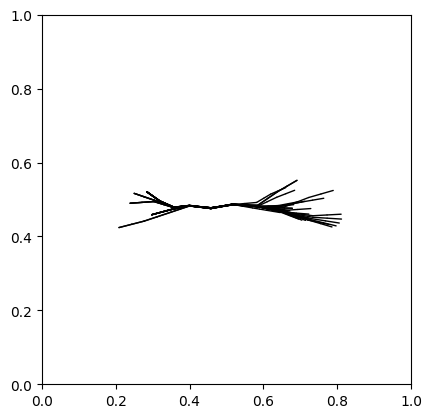

In [264]:
def plot_edges_with_control_points(edges):
    fig, ax = plt.subplots()
    for edge, control_points in edges.items():
        # Iterate through the control points of the edge to draw lines between them
        for i in range(len(control_points) - 1):
            start_point = control_points[i]
            end_point = control_points[i + 1]

            # Create a connection patch between the start and end points
            conn_patch = ConnectionPatch(start_point, end_point, "figure fraction", "figure fraction",
                                         arrowstyle="-", shrinkA=0, shrinkB=0,
                                         mutation_scale=10, fc="w")
            fig.add_artist(conn_patch)

    # Set the axis limits to ensure all points are visible
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')  # Keep aspect ratio to 1 to maintain the scale
    plt.show()

plot_edges_with_control_points(result)

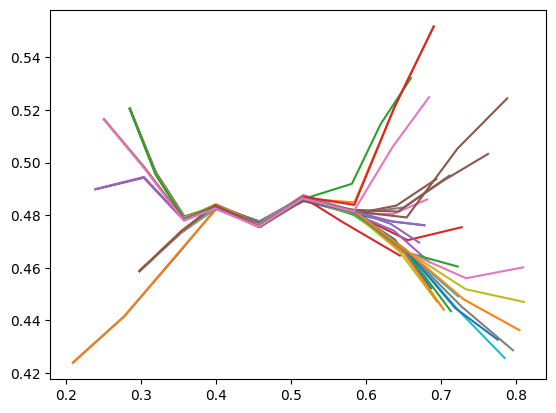

In [261]:
for edge, control_points in result.items():
    x_coords, y_coords = zip(*control_points)
    plt.plot(x_coords, y_coords)

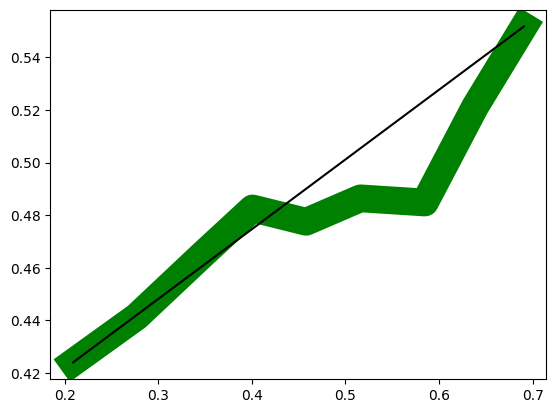

In [260]:

x_coords1, y_coords1 = zip(*result[('n66', 'n332')])
x_coords2, y_coords2 = zip(*g.edges[('n66', 'n332')].fig_coordinates)
plt.plot(x_coords1,y_coords1, color="green", lw=20)
plt.plot(x_coords2,y_coords2,color="black")

In [17]:
dot_file_path = "../Datasets/devonshiredebate_withclusters.dot"
subgraphs=["Youngest Devonian Strata", "Gap in the Sequence of Devonshi","Dating of the Culm Limestone","Rocks, Fossils and Time","Fossils in Pre-Old Red Sandston",
                        "Other Regions Than Devonshire","Evidence","Universalities","Dating of the Non-Culm"]

Updating Figure
Updating Figure


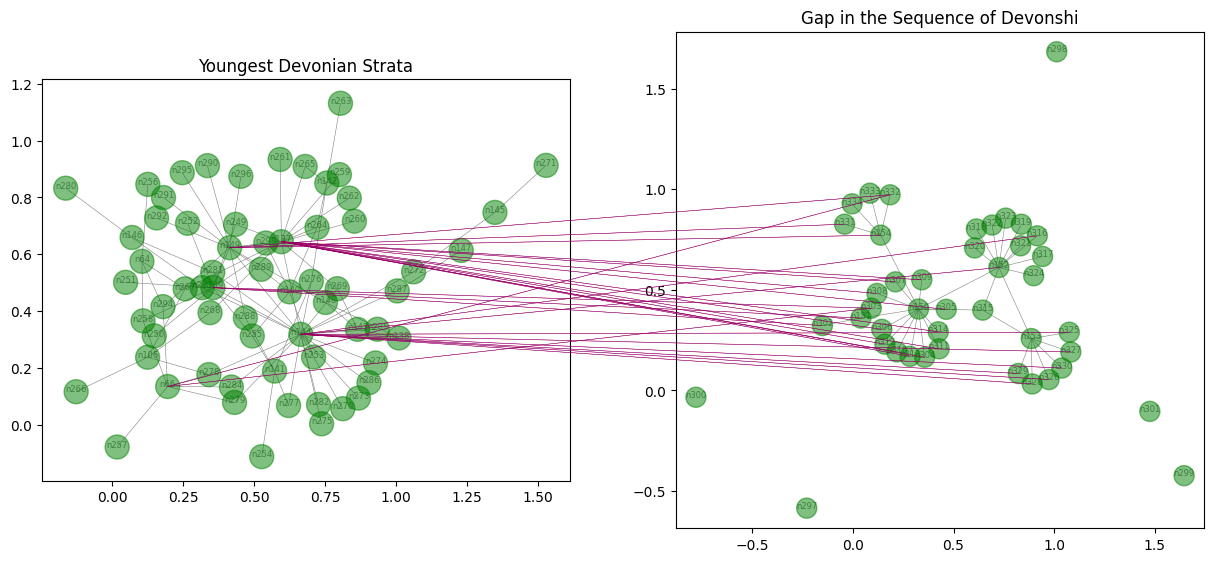

In [216]:
g = Graph(dot_file_path,subgraphs=True,selected_subgraphs=subgraphs[0:2])
g.random_layout(subgraphs=True)
g.spring_embedder_f()
fig = g.return_subplots()

In [149]:
g.edges[('n66', 'n303')].fig_coordinates

(array([0.32223213, 0.4356544 ]), array([0.76345176, 0.54874342]))

In [256]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Assuming `fig` is your figure and `bundled_edges` is the output from the edge bundling
# `bundled_edges` is a dict with edge identifiers as keys and lists of control points (x, y) as values

def plot_bundled_edges(fig, bundled_edges):
    for edge, control_points in bundled_edges.items():
        # Extract X and Y coordinates from control points
        x_coords, y_coords = zip(*control_points)

        # Create a Line2D instance for the edge
        line = Line2D(x_coords, y_coords, transform=fig.transFigure, color='blue', lw=2)

        # Add the line to the figure
        fig.lines.append(line)

    # Redraw the figure to show the updates
    fig.canvas.draw()

# Example usage
